ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    name = 'NINST'; format = '3J'
    name = 'NVISITS'; format = 'J'
    name = 'COMBTYPE'; format = 'J'
    name = 'COMMISS'; format = 'I'
    name = 'SNR'; format = 'E'
    name = 'STARFLAG'; fo

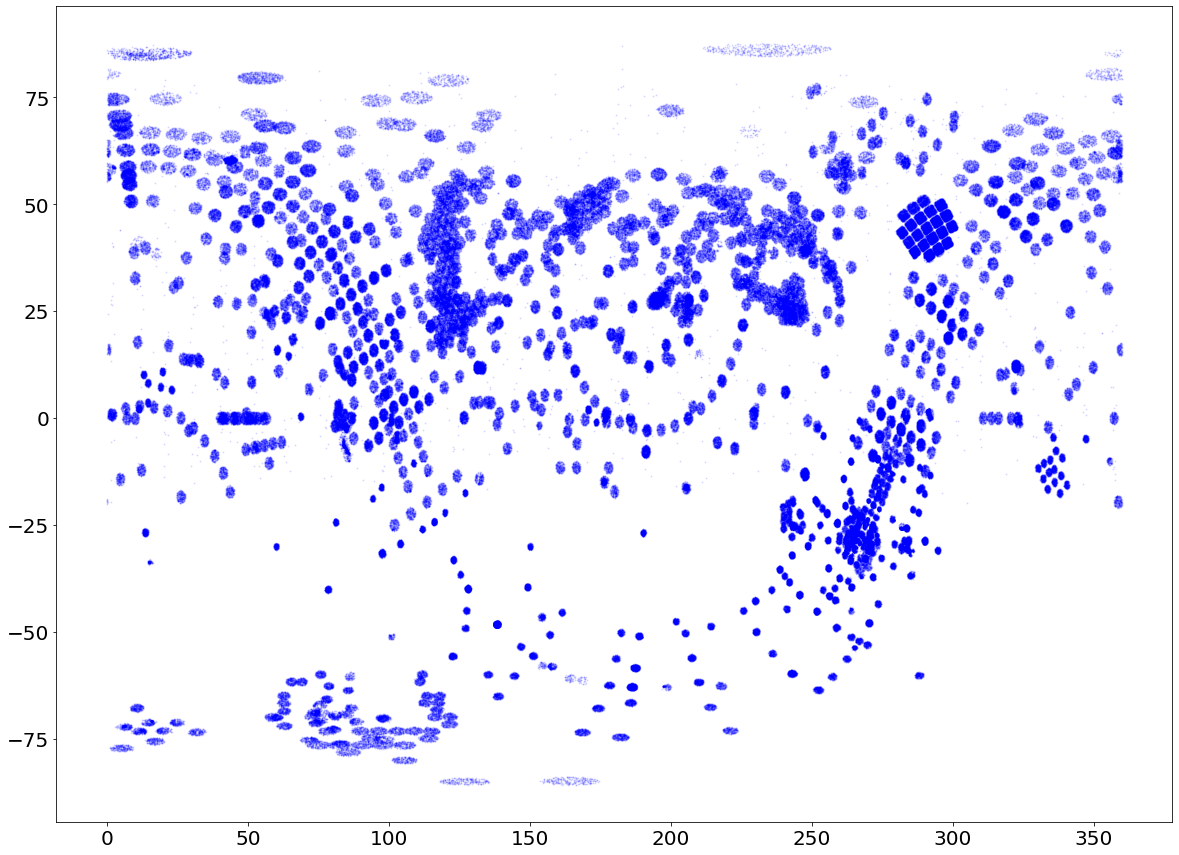

In [82]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gaussian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('allStarLite-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolean Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]

gda = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['GLAT'] > -1) & (star['GLAT'] < 1) & (star['TEFF'] > 0) &\
(star['LOGG'] > 0)
gooda = np.where(gda)[0]

gdbd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['Fe_H'] > -9000) & (star['O_FE'] > -9000) &\
(star['GLAT'] < -10)
goodbd = np.where(gdbd)[0]

gdc = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['Fe_H'] > -9000) & (star['O_FE'] > -9000) &\
(star['GLAT'] > -2) & (star['GLAT'] < 2)
goodc = np.where(gdc)[0]

gdd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['Fe_H'] > -5000) & (star['O_FE'] > -5000) &\
(star['GLAT'] < -10) & (star['J_ERR'] < 6) & (star['K_ERR'] < 6) &\
(star['J_ERR'] > -6) & (star['K_ERR'] > -6)
goodd = np.where(gdd)[0]

gde = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['GLAT'] > -10) & (star['GLAT'] < 10)
goode = np.where(gde)[0]

gdf = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['NVISITS'] >= 1)
goodf = np.where(gdf)[0]

gdg = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['FE_H'] > -9000) & (star['NI_FE'] > -9000)
goodg = np.where(gdg)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

In [96]:
def mcFit3(fnc, x, x_err, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    a_err = list()
    b_err = list()
    c_err = list()
    iters = 50 
    for i in range(iters):
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(x))

        y_adj = y + y_err*weightsy
        x_adj = x + (1/2)*weightsx

        params, other = opt.curve_fit(fnc, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        a_err.append(params[0])
        b_err.append(params[1])
        c_err.append(params[2])
    
    return a, b, c, a_err, b_err, c_err

def mcFit4(fnc, x, x_err, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    d = list()
    a_err = list()
    b_err = list()
    c_err = list()
    d_err = list()
    iters = 50
    for i in range(iters):
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(x))

        y_adj = y + y_err*weightsy
        x_adj = x + (1/2)*weightsx

        params, other = opt.curve_fit(fnc, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
        a_err.append(other[0,0])
        b_err.append(other[1,1])
        c_err.append(other[2,2])
        d_err.append(other[3,3])        
    
    return a, b, c, d, a_err, b_err, c_err, d_err


def mcFit3y(fnc, x, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    a_err = list()
    b_err = list()
    c_err = list()
    iters = 50
    for i in range(iters):
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x

        params, other = opt.curve_fit(fnc, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        a_err.append(other[0,0])
        b_err.append(other[1,1])
        c_err.append(other[2,2])
    
    return a,b,c,a_err,b_err,c_err


def mcFit4y(fnc, x, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    d = list()
    a_err = list()
    b_err = list()
    c_err = list()
    d_err = list()
    iters = 50 
    for i in range(iters):
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x
        
        params, other = opt.curve_fit(fnc, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
        a_err.append(other[0,0])
        b_err.append(other[1,1])
        c_err.append(other[2,2])
        d_err.append(other[3,3])        
    
    return a, b, c, d, a_err, b_err, c_err, d_err


def mcFitlin(fnc, x, x_err, y, y_err):
    slopes = list()
    y_ints = list()
    slopes_err = list()
    y_ints_err = list()
    iters = 50
    for i in range(iters):
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(x))

        y_adj = y + y_err*weightsy
        x_adj = x + (1/2)*weightsx

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
        slopes_err.append(other[0,0])
        y_ints_err.append(other[1,1])
    
    return slopes, y_ints, slopes_err, y_ints_err


def mcFitliny(fnc, x, y, y_err):
    slopes = list()
    y_ints = list()
    slopes_err = list()
    y_ints_err = list()
    iters = 50
    for i in range(iters):
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x
        
        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
        slopes_err.append(params[0])
        y_ints_err.append(params[1])
    
    return slopes, y_ints, slopes_err, y_ints_err

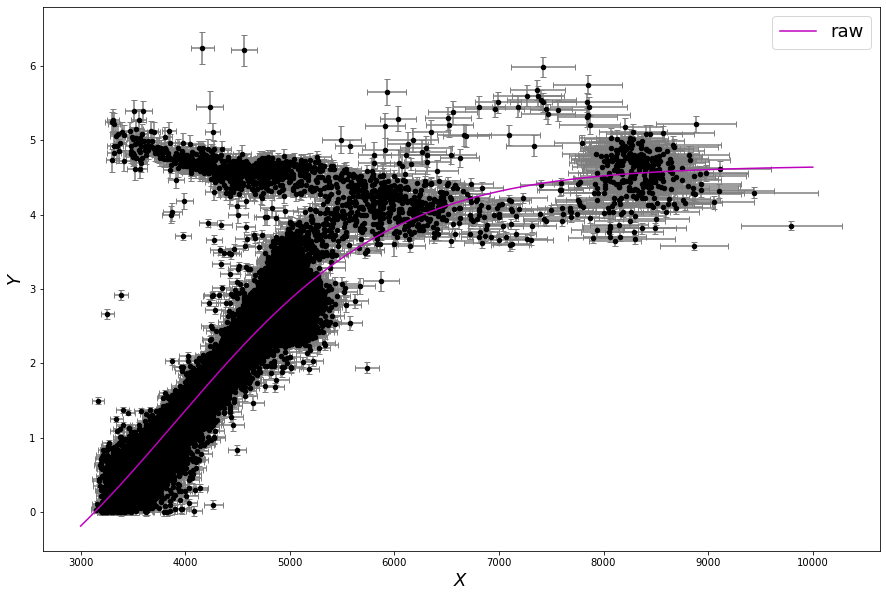

3905.5368281012725 0.0009503633159891457 6.897821807020495 -2.2369928586261327
2250.0422219423695 5.306462429138151e-10 0.036499055390618595 0.028549815789161784


In [57]:
#A sigmoid
siga, sigb, sigc, sigd, sig_erra, sig_errb, sig_errc, sig_errd = mcFit4(sigmoid, star['TEFF'][gooda], star['TEFF_ERR'][gooda], star['LOGG'][gooda],\
                            star['LOGG_ERR'][gooda], [0,0,0,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['TEFF'][gooda], star['LOGG'][gooda],s=20,c='black',zorder=2)
x=np.linspace(3000,10000,10000)

ax1.plot(x, sigmoid(x, np.mean(siga), np.mean(sigb), np.mean(sigc), np.mean(sigd)), label='raw', c='m')
ax1.errorbar(star['TEFF'][gooda], star['LOGG'][gooda], xerr=star['TEFF_ERR'][gooda], yerr=star['LOGG_ERR'][gooda],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(siga), np.mean(sigb), np.mean(sigc), np.mean(sigd))
print(np.mean(sig_erra), np.mean(sig_errb), np.mean(sig_errc), np.mean(sig_errd))
plt.show()

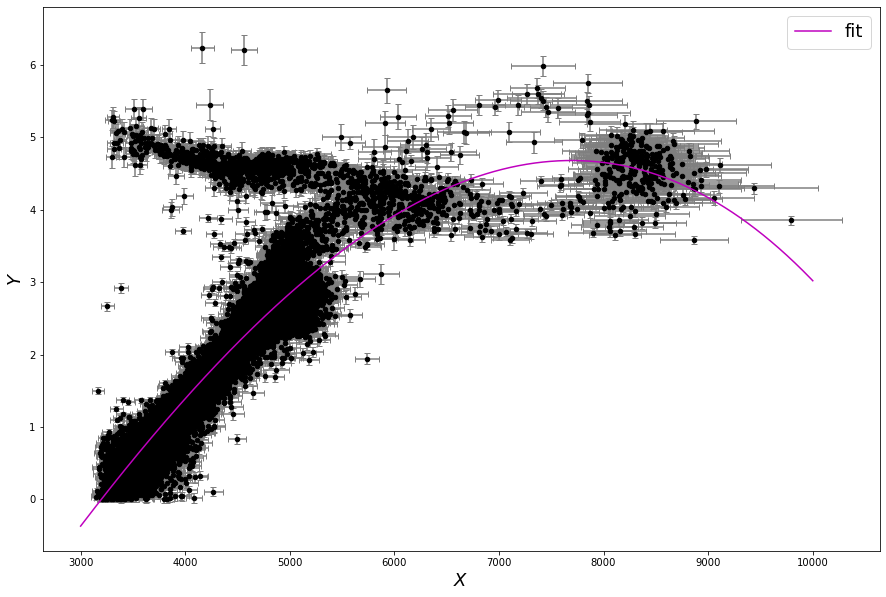

-1.1888298351622182e-11 -1.0700640224833896e-08 0.0022760148802724225 -6.782317098268907
4.026097541487659e-24 1.1352804383551965e-15 3.196326066971261e-08 0.09229265650781299


In [47]:
#A poly3
polya, polyb, polyc, polyd, poly_erra, poly_errb, poly_errc, poly_errd = mcFit4(poly3, star['TEFF'][gooda], star['TEFF_ERR'][gooda], star['LOGG'][gooda],\
                            star['LOGG_ERR'][gooda], [0,0,0,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['TEFF'][gooda], star['LOGG'][gooda],s=20,c='black',zorder=2)
x=np.linspace(3000,10000,10000)

ax1.plot(x, poly3(x, np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd)), label='fit', c='m')
ax1.errorbar(star['TEFF'][gooda], star['LOGG'][gooda], xerr=star['TEFF_ERR'][gooda], yerr=star['LOGG_ERR'][gooda],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd))
print(np.mean(poly_erra), np.mean(poly_errb), np.mean(poly_errc), np.mean(poly_errd))
plt.show()

-0.00021138182433209265 5.528843055119426
8.539577058329486e-11 0.0022853826643388004


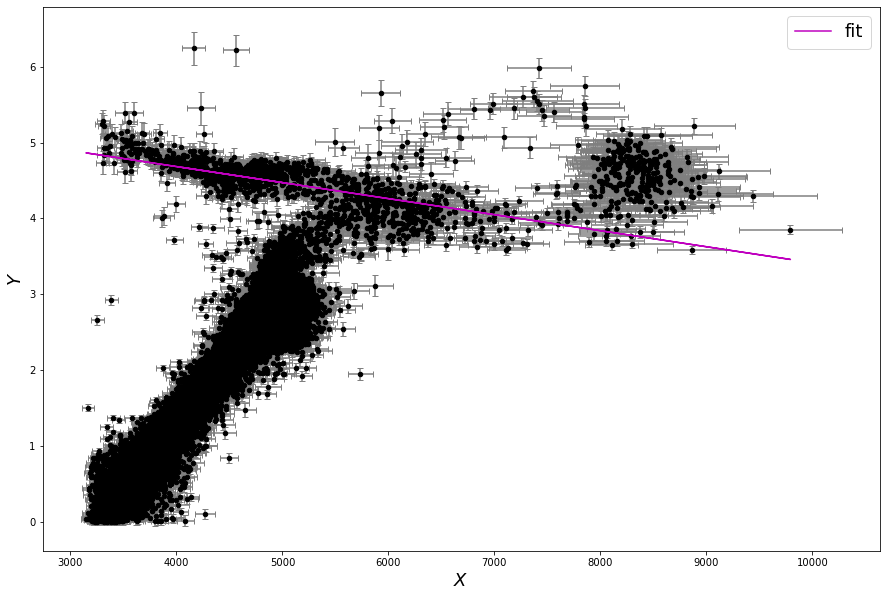

In [76]:
#A lin
aln = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
(star['GLAT'] > -1) & (star['GLAT'] < 1) & (star['TEFF'] > 0) &\
(star['LOGG'] > 3.75) & (star['TEFF'] < 7500)
alin = np.where(aln)[0]

slope, intercept, slope_err, int_err = (mcFitlin(linear,star['TEFF'][alin], star['TEFF_ERR'][alin], star['LOGG'][alin],\
                          star['LOGG_ERR'][alin]))

fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(111)
ax1.scatter(star['TEFF'][gooda], star['LOGG'][gooda],s=20,c='black',zorder=2)
ax1.errorbar(star['TEFF'][gooda], star['LOGG'][gooda], xerr=star['TEFF_ERR'][gooda],\
             yerr=(star['LOGG_ERR'][gooda]), c='tab:gray', fmt='.',\
             markersize=1, capsize=3, zorder=0)

ax1.plot(star['TEFF'][gooda], linear(star['TEFF'][gooda], np.mean(slope), np.mean(intercept)), label='fit', c='m')
xlin=np.linspace(3000,10000,10000)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)
print(np.mean(slope), np.mean(intercept))
print(np.mean(slope_err), np.mean(int_err))
plt.show()

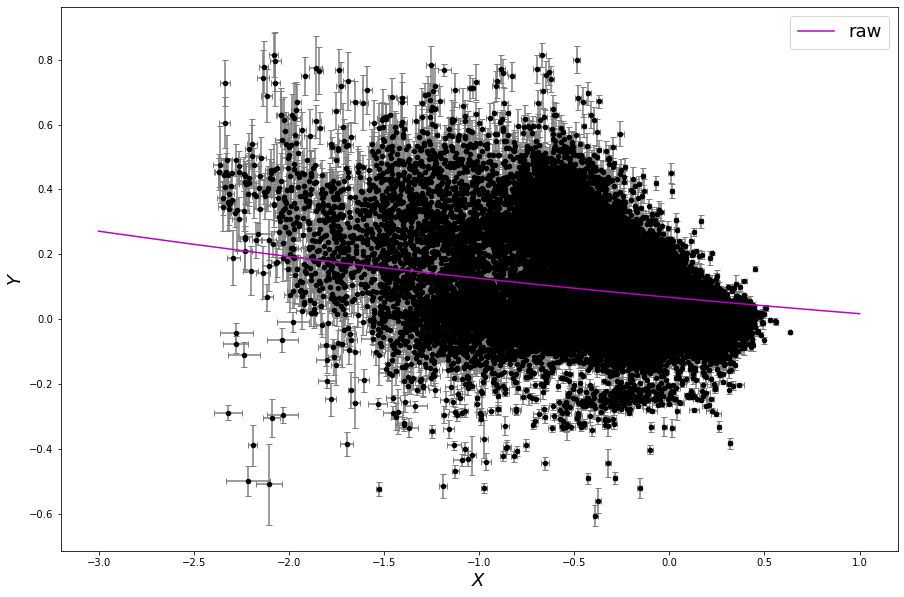

0.3606278991806298 -0.14610421581938876 0.02799444888828311 -0.3035792990400866
680884867.7507482 0.0009972522519445532 4124671321.2851787 0.011531795500723923


In [55]:
#B exponential
expa, expb, expc, expd, exp_erra, exp_errb, exp_errc, exp_errd = mcFit4(exponential, star['FE_H'][goodbd], star['FE_H_ERR'][goodbd], star['O_FE'][goodbd],\
                            star['O_FE_ERR'][goodbd], [0,0,0,0])
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['FE_H'][goodbd], star['O_FE'][goodbd],s=20,c='black',zorder=2)
x=np.linspace(-3,1,10000)

ax1.plot(x, exponential(x, np.mean(expa), np.mean(expb), np.mean(expc), np.mean(expd)), label='raw', c='m')
ax1.errorbar(star['FE_H'][goodbd], star['O_FE'][goodbd], xerr=star['FE_H_ERR'][goodbd], yerr=star['O_FE_ERR'][goodbd],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)
plt.show()

print(np.mean(expa), np.mean(expb), np.mean(expc), np.mean(expd))
print(np.mean(exp_erra), np.mean(exp_errb), np.mean(exp_errc), np.mean(exp_errd))
plt.show()

-0.05542056405663181 0.07138407725378612
7.338495219784939e-07 3.60598008161099e-07


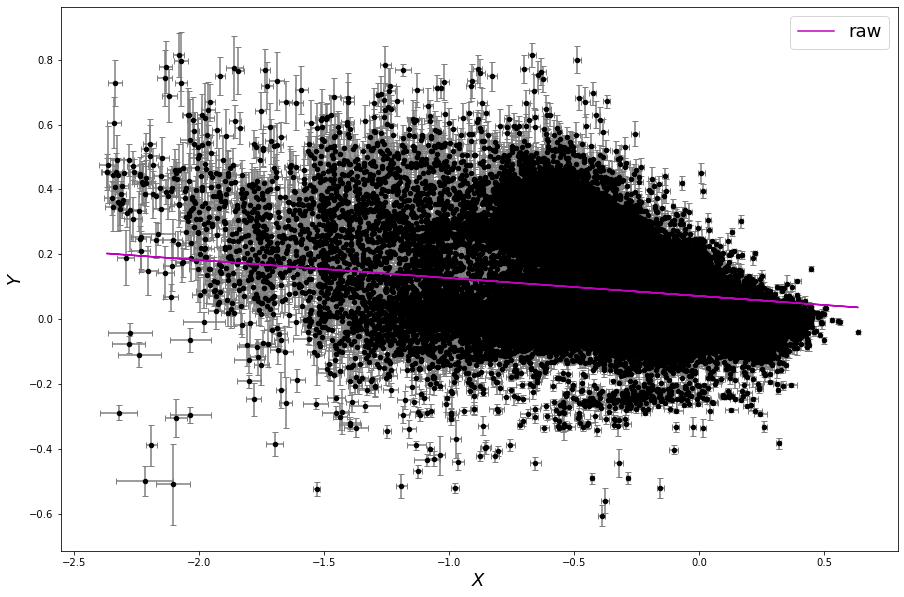

In [33]:
#B linear
slope, intercept, slope_err, int_err = (mcFitlin(linear,star['FE_H'][goodbd], star['FE_H_ERR'][goodbd], star['O_FE'][goodbd],\
                          (star['O_FE_ERR'][goodbd])))

fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_subplot(111)
ax2.scatter(star['FE_H'][goodbd], star['O_FE'][goodbd],s=20,c='black',zorder=2)
ax2.errorbar(star['FE_H'][goodbd], star['O_FE'][goodbd], xerr=star['FE_H_ERR'][goodbd],\
             yerr=star['O_FE_ERR'][goodbd], c='tab:gray', fmt='.',\
             markersize=1, capsize=3, zorder=0)


ax2.set_xlabel('$X$', fontsize=18)
ax2.set_ylabel('$Y$', fontsize=18)
ax2.plot(star['FE_H'][goodbd], linear(star['FE_H'][goodbd], np.mean(slope), np.mean(intercept)), label='raw', c='m')
ax2.legend(loc='best', fontsize=18)
print(np.mean(slope), np.mean(intercept))
print(np.mean(slope_err), np.mean(int_err))

plt.show()

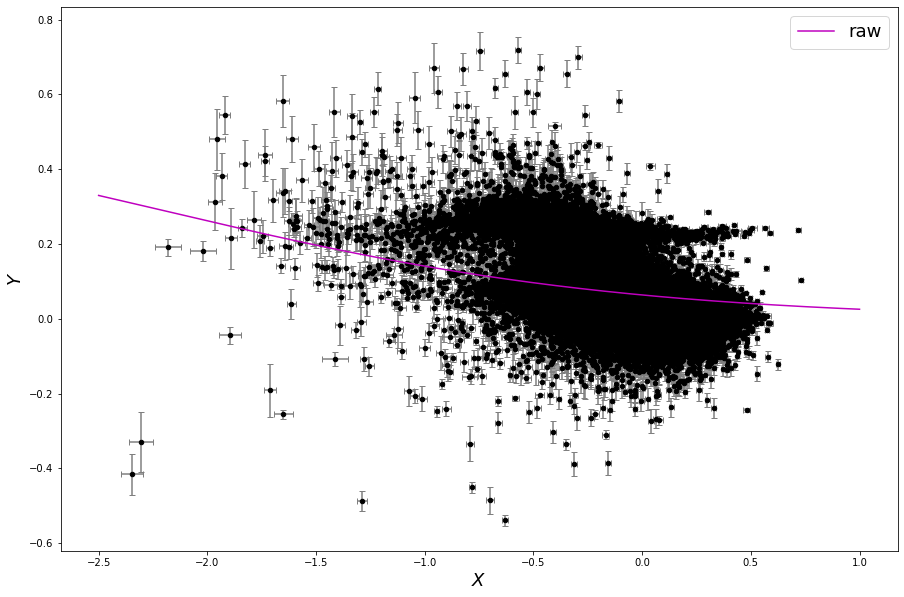

-2.2035233646816343 -0.9346416661878458 0.5836771689144002 -0.0021955038477219314
35.03584596763456 0.025673130059220624 361.10649425047603 9.168653070977437e-05


In [53]:
#C sigmoid
siga, sigb, sigc, sigd, sig_erra, sig_errb, sig_errc, sig_errd = mcFit4(sigmoid, star['FE_H'][goodc], star['FE_H_ERR']\
                            [goodc], star['O_FE'][goodc], star['O_FE_ERR'][goodc], [-1,-1,1,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['FE_H'][goodc], star['O_FE'][goodc],s=20,c='black',zorder=2)
x=np.linspace(-2.5,1,10000)

ax1.plot(x, sigmoid(x, np.mean(siga), np.mean(sigb), np.mean(sigc), np.mean(sigd)), label='raw', c='m')
ax1.errorbar(star['FE_H'][goodc], star['O_FE'][goodc], xerr=star['FE_H_ERR'][goodc], yerr=star['O_FE_ERR'][goodc],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(siga), np.mean(sigb), np.mean(sigc), np.mean(sigd))
print(np.mean(sig_erra), np.mean(sig_errb), np.mean(sig_errc), np.mean(sig_errd))
plt.show()

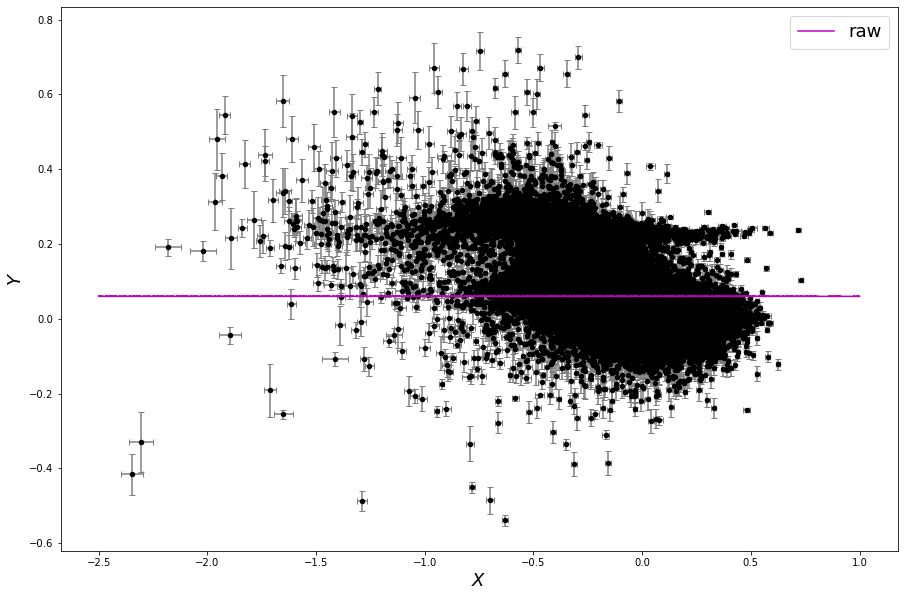

-0.0001319158786911921 -2467656.791696262 472973.22161477874 0.0601192693946328
4.523160872956975e-07 1.286336576904423 0.45723353533159655 2.2624712857262748e-07


In [54]:
#C cosfit
cosa, cosb, cosc, cosd, cos_erra, cos_errb, cos_errc, cos_errd = mcFit4(cosfit, star['FE_H'][goodc], star['FE_H_ERR'][goodc], star['O_FE'][goodc],\
                            star['O_FE_ERR'][goodc], [1,0,0,0])

fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_subplot(111)
ax2.scatter(star['FE_H'][goodc], star['O_FE'][goodc],s=20,c='black',zorder=2)
x2=np.linspace(-5,5,10000)

ax2.plot(x, cosfit(x, np.mean(cosa), np.mean(cosb), np.mean(cosc), np.mean(cosd)), label='raw', c='m')
ax2.errorbar(star['FE_H'][goodc], star['O_FE'][goodc], xerr=star['FE_H_ERR'][goodc], yerr=star['O_FE_ERR'][goodc],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax2.set_xlabel('$X$', fontsize=18)
ax2.set_ylabel('$Y$', fontsize=18)

ax2.legend(loc='best', fontsize=18)
print(np.mean(cosa), np.mean(cosb), np.mean(cosc), np.mean(cosd))
print(np.mean(cos_erra), np.mean(cos_errb), np.mean(cos_errc), np.mean(cos_errd))
plt.show()

-5.983457890196177e-08 0.0001817049834088976 1.223923393071884
-5.983457890196177e-08 0.0001817049834088976 1.223923393071884


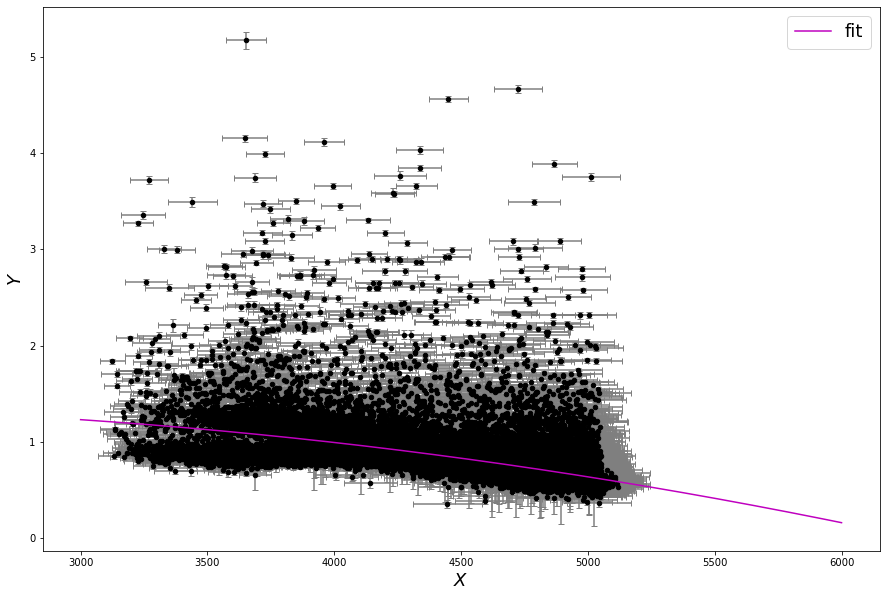

In [97]:
#D poly2
polya, polyb, polyc, poly_erra, poly_errb, poly_errc = mcFit3(poly2, star['TEFF'][goodd], star['TEFF_ERR'][goodd], (star['J'][goodd]-star['K'][goodd]),\
                            np.sqrt(star['J_ERR'][goodd]**2+star['K_ERR'][goodd]**2), [1,1,1])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['TEFF'][goodd], (star['J'][goodd]-star['K'][goodd]),s=20,c='black',zorder=2)
x=np.linspace(3000,6000,10000)

ax1.plot(x, poly2(x, np.mean(polya), np.mean(polyb), np.mean(polyc)), label='fit', c='m')
ax1.errorbar(star['TEFF'][goodd], (star['J'][goodd]-star['K'][goodd]), xerr=star['TEFF_ERR'][goodd], yerr=np.sqrt(star['J_ERR'][goodd]**2+star['K_ERR'][goodd]**2),\
c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)
print(np.mean(polya), np.mean(polyb), np.mean(polyc))
print(np.mean(poly_erra), np.mean(poly_errb), np.mean(poly_errc))
plt.show()

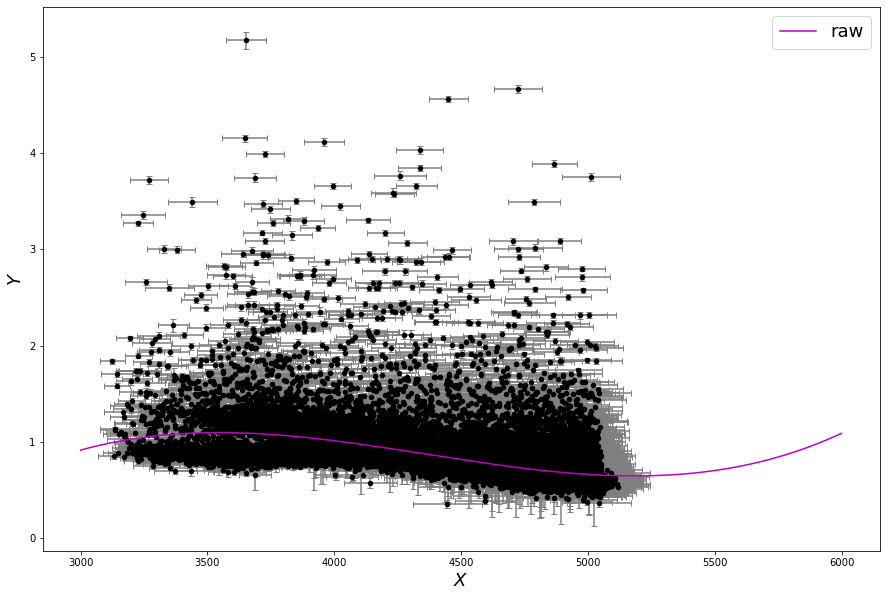

2.037839185419197e-10 -2.668862428277422e-06 0.01123939995835944 -14.286257629190022
8.058269904868275e-23 1.322659466893456e-14 2.3867070200268606e-07 0.47341555914157113


In [60]:
#D poly3
polya, polyb, polyc, polyd, poly_erra, poly_errb, poly_errc, poly_errd = mcFit4(poly3, star['TEFF'][goodd],\
                            star['TEFF_ERR'][goodd], (star['J'][goodd]-star['K'][goodd]),\
                            (np.sqrt(star['J_ERR'][goodd]**2+star['K_ERR'][goodd]**2)), [0,0,0,0])
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['TEFF'][goodd], (star['J'][goodd]-star['K'][goodd]),s=20,c='black',zorder=2)
x=np.linspace(3000,6000,10000)

ax1.plot(x, poly3(x, np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd)), label='raw', c='m')
ax1.errorbar(star['TEFF'][goodd], (star['J'][goodd]-star['K'][goodd]), xerr=star['TEFF_ERR'][goodd], yerr=np.sqrt(star['J_ERR'][goodd]**2+star['K_ERR'][goodd]**2),\
c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd))
print(np.mean(poly_erra), np.mean(poly_errb), np.mean(poly_errc), np.mean(poly_errd))
plt.show()

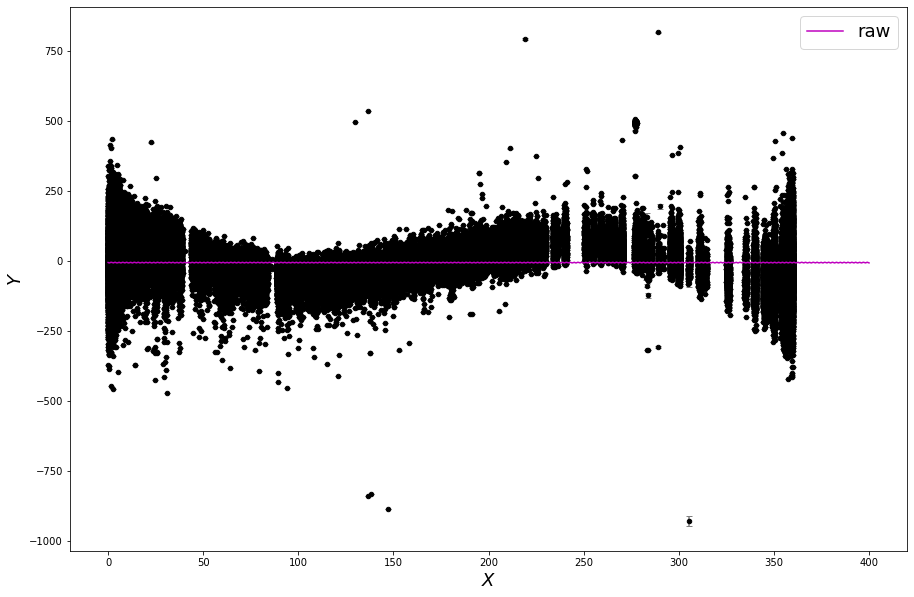

-1.13740005314559 -3.0986245100114114 1.8490222008646249 -5.143921750794763
0.050387072413322825 176882.76674635845 22977556829.852917 1008243284565.575


In [64]:
#E cos
cosa, cosb, cosc, cosd, cos_erra, cos_errb, cos_errc, cos_errd = mcFit4y(cosfit, star['GLON'][goode], star['VHELIO_AVG'][goode],\
                            star['VERR'][goode], [0,0,0,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['GLON'][goode], star['VHELIO_AVG'][goode],s=20,c='black',zorder=2)
x=np.linspace(0,400,10000)

ax1.plot(x, cosfit(x, np.mean(cosa), np.mean(cosb), np.mean(cosc), np.mean(cosd)), label='raw', c='m')
ax1.errorbar(star['GLON'][goode], star['VHELIO_AVG'][goode], yerr=star['VERR'][goode],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(cosa), np.mean(cosb), np.mean(cosc), np.mean(cosd))
print(np.mean(log_erra), np.mean(log_errb), np.mean(log_errc), np.mean(log_errd))
plt.show()

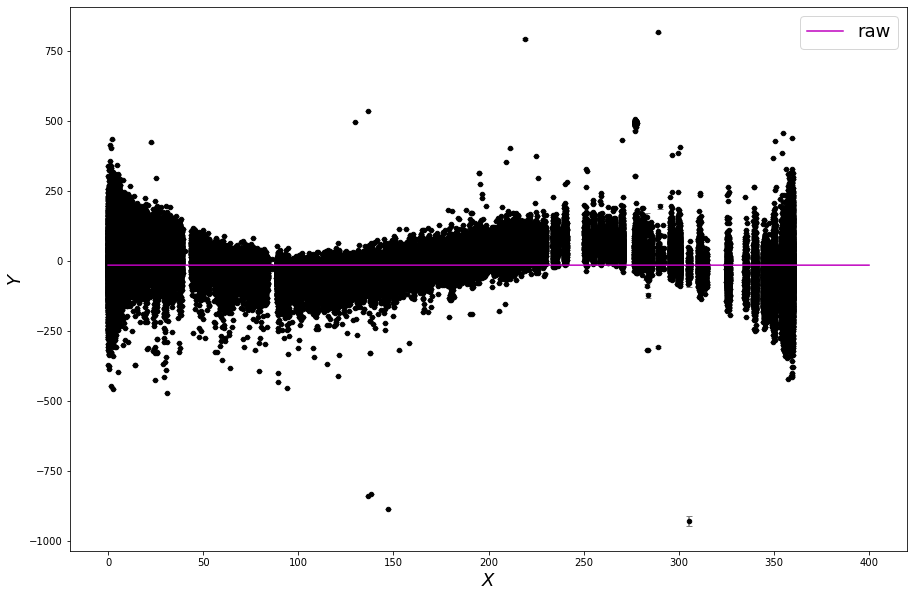

-0.0006641356658979219 0.04117447394812566 -3.649658148541745 -1.4151549389504239
108435.85946003308 6.068415546628635e-06 235795210765.65414 0.042075712096631246


In [63]:
#E exp

expa, expb, expc, expd, exp_erra, exp_errb, exp_errc, exp_errd = mcFit4y(exponential, star['GLON'][goode], star['VHELIO_AVG'][goode],\
                            star['VERR'][goode], [0,0,0,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['GLON'][goode], star['VHELIO_AVG'][goode],s=20,c='black',zorder=2)
x=np.linspace(0,400,10000)

ax1.plot(x, exponential(x, np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd)), label='raw', c='m')
ax1.errorbar(star['GLON'][goode], star['VHELIO_AVG'][goode], yerr=star['VERR'][goode],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(expa), np.mean(expb), np.mean(expc), np.mean(expd))
print(np.mean(exp_erra), np.mean(exp_errb), np.mean(exp_errc), np.mean(exp_errd))
plt.show()

0.06599870515537845 0.1614756808121583
0.06599870515537845 0.1614756808121583


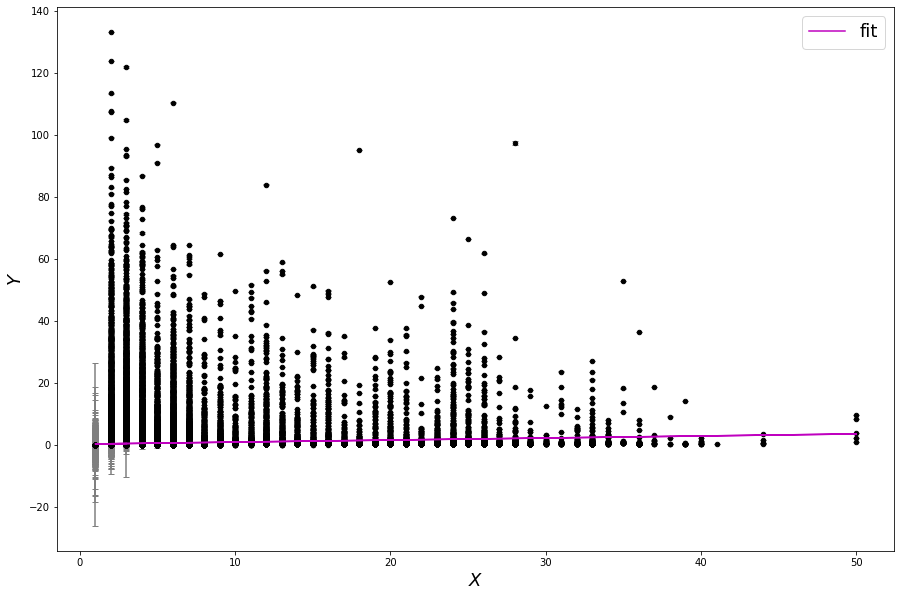

In [80]:
#F linear
slope, intercept, slope_err, int_err = (mcFitliny(linear,star['NVISITS'][goodf], star['VSCATTER'][goodf], star['VERR'][goodf]))

fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(111)
ax1.scatter(star['NVISITS'][goodf], star['VSCATTER'][goodf],s=20,c='black',zorder=2)
ax1.errorbar(star['NVISITS'][goodf], star['VSCATTER'][goodf], \
             yerr=star['VERR'][goodf], c='tab:gray', fmt='.',\
             markersize=1, capsize=3, zorder=0)

ax1.plot(star['NVISITS'][goodf], linear(star['NVISITS'][goodf], np.mean(slope), np.mean(intercept)), label='fit', c='m')

ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)
print(np.mean(slope), np.mean(intercept))
print(np.mean(slope_err), np.mean(int_err))
plt.show()

-0.002570943945266891 0.12167218011483108 0.028636006340273686
1.3150515706896007e-08 7.389869469057037e-06 6.473753377750058e-05


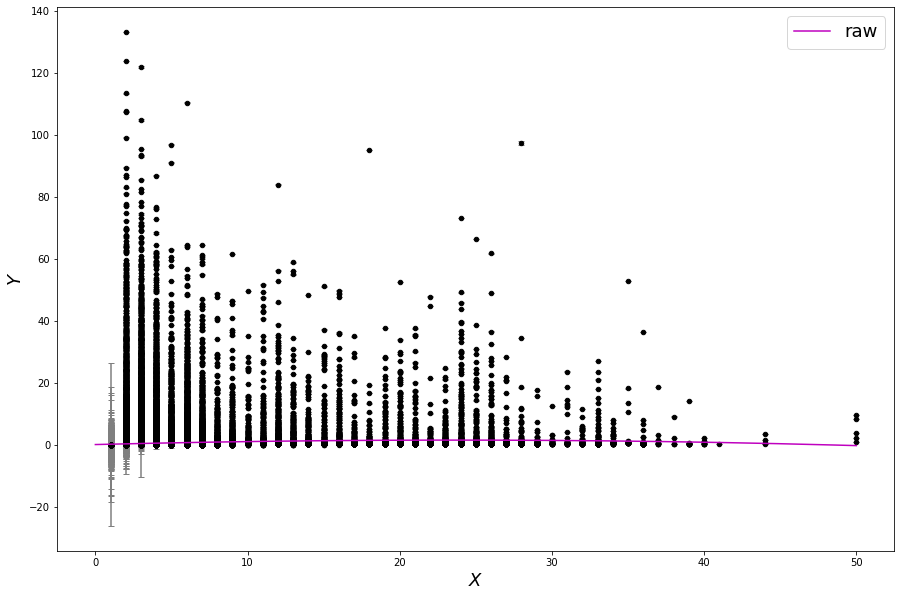

In [72]:
#F poly2
polya, polyb, polyc, poly_erra, poly_errb, poly_errc = mcFit3y(poly2, star['NVISITS'][goodf],\
                            star['VSCATTER'][goodf], star['VERR'][goodf], [0,0,0])


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(star['NVISITS'][goodf], star['VSCATTER'][goodf],s=20,c='black',zorder=2)
x=np.linspace(0,50,10000)

ax.plot(x, poly2(x, np.mean(polya), np.mean(polyb), np.mean(polyc)), label='raw', c='m')
ax.errorbar(star['NVISITS'][goodf], star['VSCATTER'][goodf], yerr=star['VERR'][goodf],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
print(np.mean(polya), np.mean(polyb), np.mean(polyc))
print(np.mean(poly_erra), np.mean(poly_errb), np.mean(poly_errc))
plt.show()

0.0034774156192648124 0.01971831394689148
3.63629759678396e-08 1.509283466772329e-08


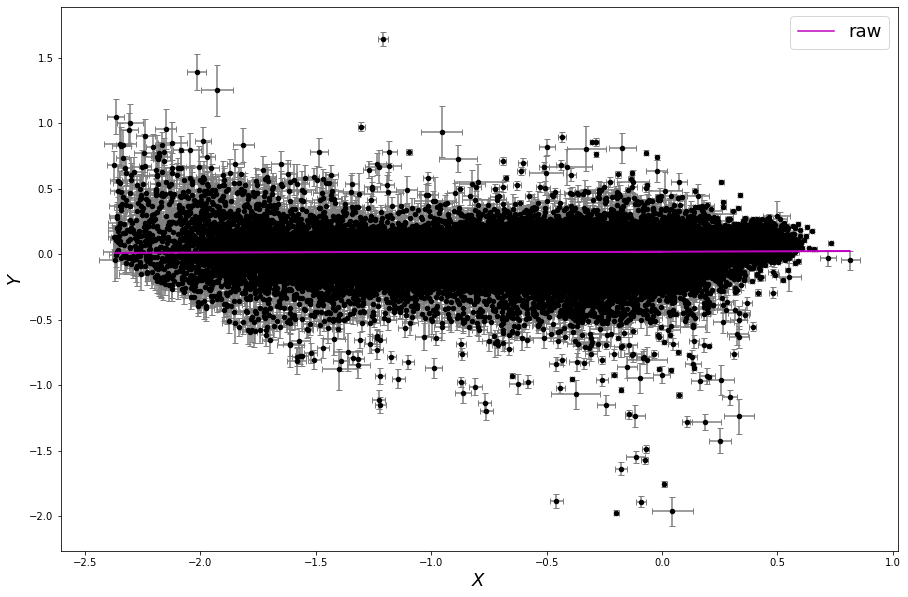

In [62]:
#G linear
slope, intercept, slope_err, int_err = (mcFitlin(linear,star['FE_H'][goodg], star['FE_H_ERR'][goodg], star['NI_FE'][goodg],\
                          (star['NI_FE_ERR'][goodg])))

fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(111)
ax1.scatter(star['FE_H'][goodg], star['NI_FE'][goodg],s=20,c='black',zorder=2)
ax1.errorbar(star['FE_H'][goodg], star['NI_FE'][goodg], xerr=star['FE_H_ERR'][goodg],\
             yerr=star['NI_FE_ERR'][goodg], c='tab:gray', fmt='.',\
             markersize=1, capsize=3, zorder=0)

ax1.plot(star['FE_H'][goodg], linear(star['FE_H'][goodg], np.mean(slope), np.mean(intercept)), label='raw', c='m')

ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(slope), np.mean(intercept))
print(np.mean(slope_err), np.mean(int_err))
plt.show()

0.0006746584093279797 0.0016520192311431175 0.0034321351766453817 0.019236212344193884
2.9294582217862986e-08 8.400912793164522e-08 6.956209817857891e-08 2.2499548140663818e-08


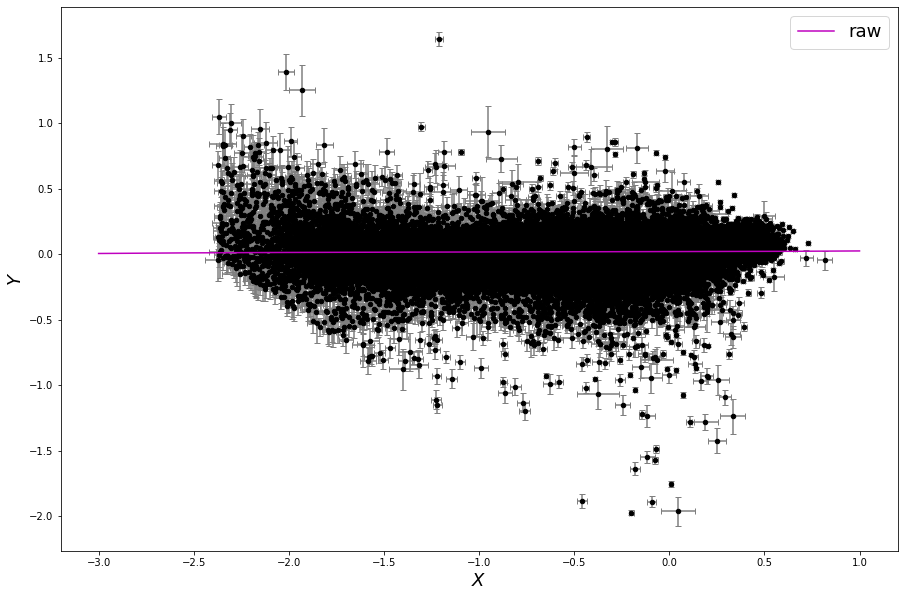

In [78]:
#G poly3
polya, polyb, polyc, polyd, poly_erra, poly_errb, poly_errc, poly_errd = mcFit4(poly3, star['FE_H'][goodg], star['FE_H_ERR'][goodg], star['NI_FE'][goodg],\
                            star['NI_FE_ERR'][goodg], [0,0,0,0])

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.scatter(star['FE_H'][goodg], star['NI_FE'][goodg],s=20,c='black',zorder=2)
x=np.linspace(-3,1,10000)

ax1.plot(x, poly3(x, np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd)), label='raw', c='m')
ax1.errorbar(star['FE_H'][goodg], star['NI_FE'][goodg], xerr=star['FE_H_ERR'][goodg], yerr=star['NI_FE_ERR'][goodg],\
             c='tab:gray', fmt='.', markersize=1, capsize=3, zorder=0)
ax1.set_xlabel('$X$', fontsize=18)
ax1.set_ylabel('$Y$', fontsize=18)

ax1.legend(loc='best', fontsize=18)

print(np.mean(polya), np.mean(polyb), np.mean(polyc), np.mean(polyd))
print(np.mean(poly_erra), np.mean(poly_errb), np.mean(poly_errc), np.mean(poly_errd))
plt.show()